# Song popularity prediction

## Imports

In [3]:
# Data and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import confusion_matrix



random_state = 42

## Loading the data

In [4]:
# Loading the data collected from an sqlite database

df = pd.read_csv('features.csv')

## Initial processing

In [5]:
df = df.drop(["id"], axis=1)

In [6]:
df['label'] = df['popularity'].apply(lambda x: 1 if x >= 50 else 0)

In [7]:
def drop_zeros(df, column):
    if column not in df.columns:
        raise ValueError(f"Column {column} not in dataframe")
    df = df[df[column] != 0]
    return df

## Data exploration

In [8]:
df.head()

,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,label
0,0.1640,0.652,275893,0.814,0.000,0.3600,-4.901,0.3100,91.888000,0.788,0,0
1,0.4300,0.780,252746,0.575,0.000,0.1430,-7.247,0.2730,84.491997,0.773,77,1
2,0.3310,0.624,315080,0.564,0.293,0.2560,-8.928,0.0297,111.960999,0.431,8,0
3,0.2630,0.769,240800,0.818,0.000,0.0787,-1.385,0.1920,88.016998,0.918,70,1
4,0.0196,0.420,203666,0.949,0.000,0.2840,-3.902,0.0823,163.945007,0.594,50,1


### Target analysis

<Axes: xlabel='label'>

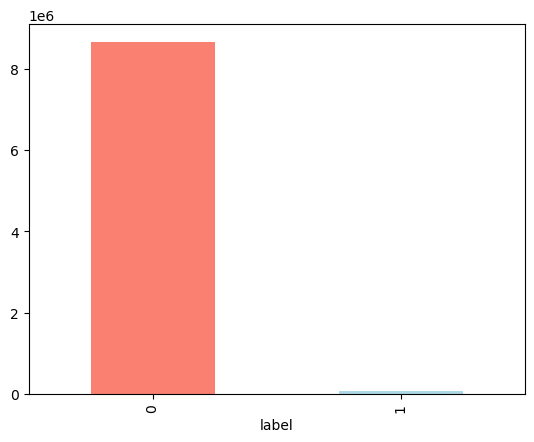

In [9]:
df["label"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [9]:
df["popularity"].value_counts()

popularity
0      3980013
1       746171
2       484899
3       363832
4       293537
        ...   
93           5
97           4
100          3
99           3
98           1
Name: count, Length: 101, dtype: int64

As we can see, the target variable is very imbalanced. Not only there are much more unpopular songs, but also songs with popularity 0 make almost 50% of the dataset. This is a problem because the model can simply predict 0 for every song and have a high accuracy. Do deal with this, let's drop the songs with popularity 0.

In [10]:
df = drop_zeros(df, "popularity")

<Axes: xlabel='label'>

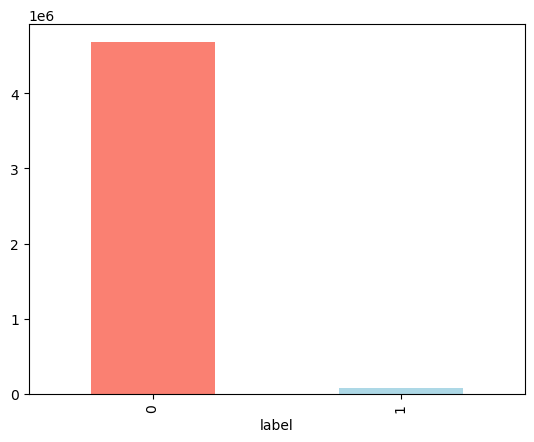

In [11]:
df["label"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

The difference is still massive, that's why for the further analysis and visualization we will use a sample of the data.

In [12]:
df_pop = df.loc[df["label"] == 1]
df_non_pop = df.loc[df["label"] == 0].sample(n=len(df_pop), random_state=random_state)

In [13]:
df_sample = pd.concat([df_pop, df_non_pop])

<Axes: xlabel='label'>

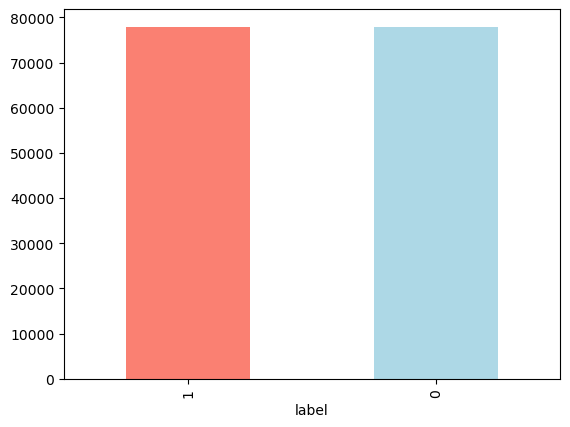

In [14]:
df_sample["label"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

### Feature analysis 

In [15]:
def get_features(df):
    return list(df.drop(["popularity", "label"], axis=1).columns)

In [16]:
def plot_dist(df, label=False): 
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

    for idx, feature in enumerate(get_features(df)):
        ax = axes[int(idx / 2), idx % 2]
        if label:    
            pop = df.loc[df["label"] == 1][feature]
            nonpop = df.loc[df["label"] == 0][feature].sample(len(pop))
            
            sns.histplot(pop, ax=ax, color="yellow", bins=40)
            sns.histplot(nonpop, ax=ax, color="purple", bins=40)
            ax.legend(["Popular", "Not popular"])
        else:
            sns.histplot(df[feature], ax=ax, color="mediumpurple", bins=40)
        ax.set_title(f'Distribution of {feature}')

    plt.tight_layout(pad=3.0)
    plt.show()

In [17]:
def plot_feature_dist(df, feature):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(df.loc[df["label"] == 1][feature], ax=ax, color="salmon", bins=40)
    sns.histplot(df.loc[df["label"] == 0].sample(45983)[feature], ax=ax, color="lightblue", bins=40)
    plt.legend(["Popular", "Not popular"])
    plt.show()

##### Acousticness

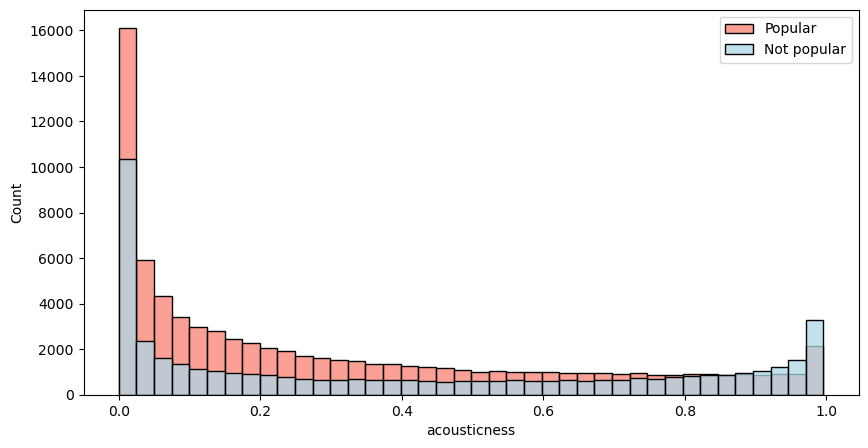

In [18]:
plot_feature_dist(df_sample, "acousticness")

We can see that popular songs tend to have much lower acousticness than unpopular songs. It shows that people prefer more "synthetic" music. 

In [19]:
df_sample["acousticness"].value_counts()

acousticness
0.995000    788
0.994000    588
0.993000    523
0.992000    476
0.991000    414
           ... 
0.000003      1
0.000002      1
0.000008      1
0.000009      1
0.000090      1
Name: count, Length: 5020, dtype: int64

##### Danceability

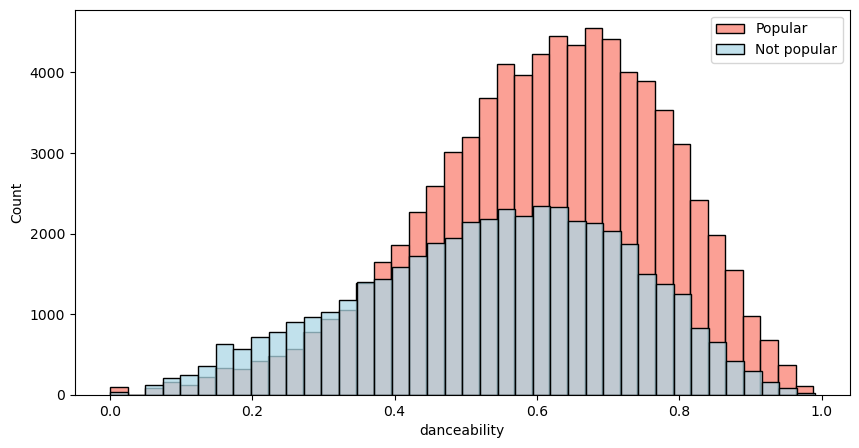

In [20]:
plot_feature_dist(df_sample, "danceability")

Here we can clearly see that popular songs tend to be more danceable. 

Also we can see an outlier spike around 0.0. We will deal with this in later steps.

##### Energy

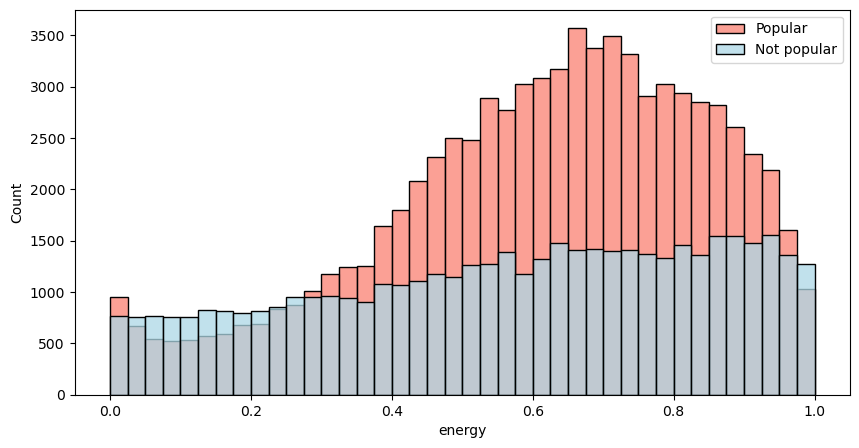

In [21]:
plot_feature_dist(df_sample, "energy")

While unpopular songs seem to be distributed very evenly, popular songs tend to have much higher energy. 

##### Instrumentalness

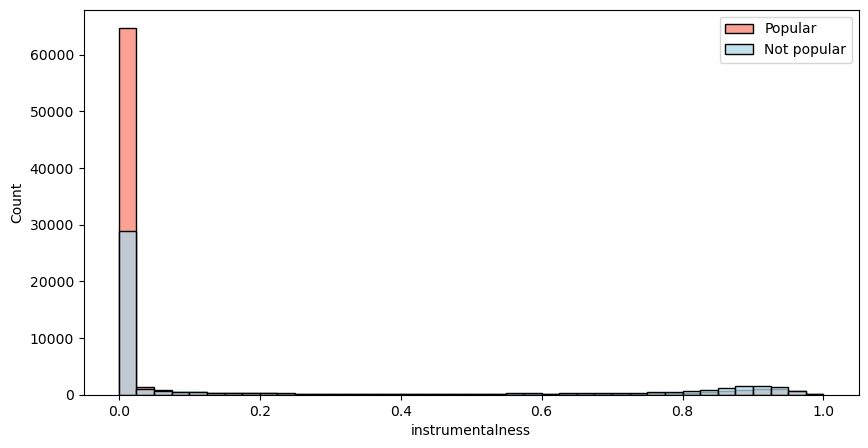

In [22]:
plot_feature_dist(df_sample, "instrumentalness")

We can clearly see a domination of low values. Also we can already see, that while there seem to be some heavily instrumental unpopular songs, almost all popular songs have very low instrumentalness.

In [23]:
df_sample["instrumentalness"].value_counts()

instrumentalness
0.000000    52417
0.905000      178
0.919000      165
0.916000      162
0.924000      161
            ...  
0.000087        1
0.092000        1
0.008000        1
0.096600        1
0.009560        1
Name: count, Length: 5400, dtype: int64

We can see that there is a massive domination of songs with 0 instrumentalness. We will have to take care of that later.

##### Liveness

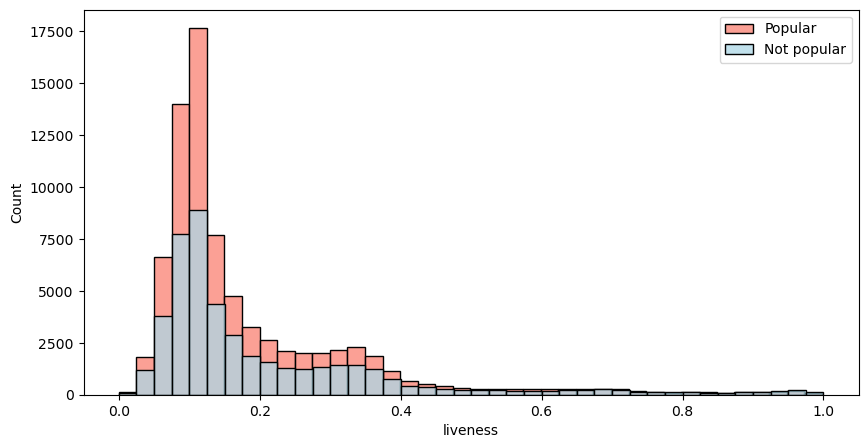

In [24]:
plot_feature_dist(df_sample, "liveness")

We can see that popular songs tend to have lower liveness. It makes sense, since studio music tend to be much more popular than live music.

##### Loudness

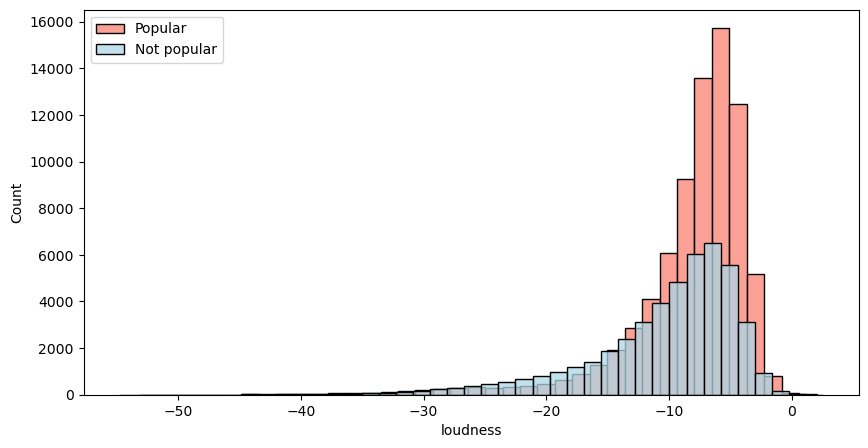

In [25]:
plot_feature_dist(df_sample, "loudness")

Popular songs tend to be much louder than unpopular songs.

##### Speechiness

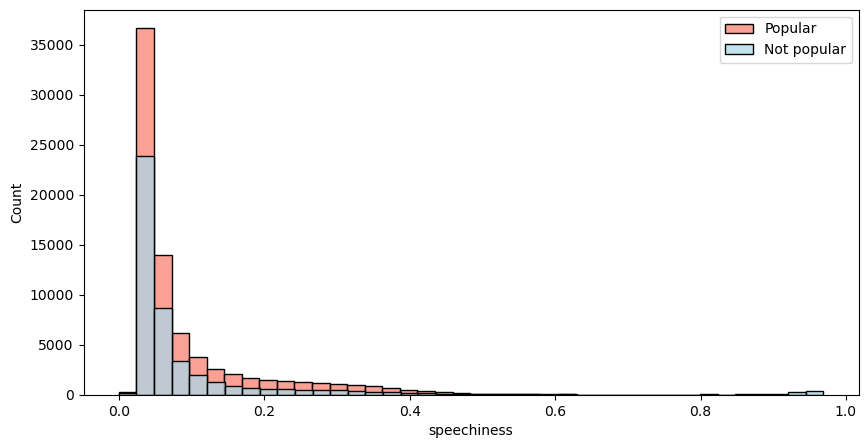

In [26]:
plot_feature_dist(df_sample, "speechiness")

Popular songs tend to have less spoken words. That however applies to all songs, since the distrubution is very similar, with an exception of a few outliers.

##### Tempo

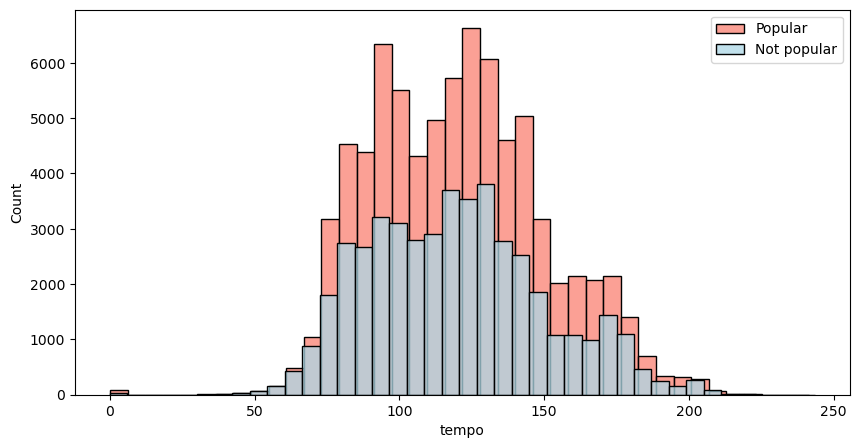

In [27]:
plot_feature_dist(df_sample, "tempo")

All songs seem to have similar tempo, with high and low extremes tending to be less popular. Also, we can see clear outlier around 0 - we will remove it later.

##### Valence

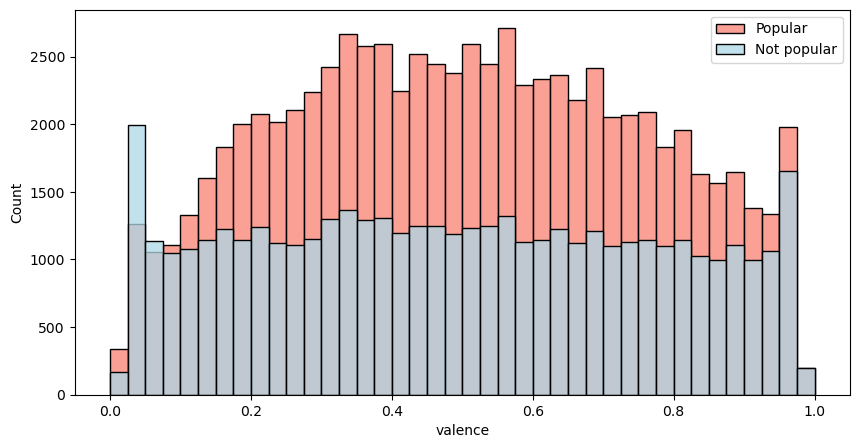

In [28]:
plot_feature_dist(df_sample, "valence")

While popular songs are mostly averagely positive, and unpopular are distributed very evenly,  we can see some peaks on both sides of the spectrum. There is a massive peak of unpopular songs at near 0 and a lower peak of both popular and unpopular songs at near 1. 

##### Duration

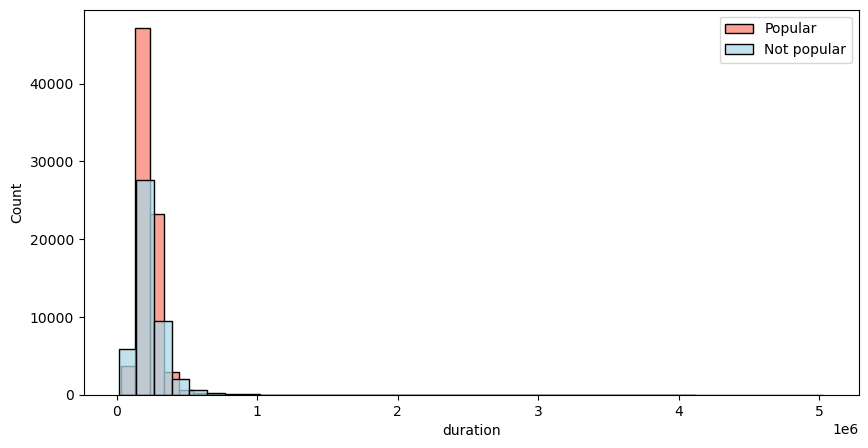

In [29]:
plot_feature_dist(df_sample, "duration")

We can see that most songs are short, below 500 000 ms. However, there are some outliers disrupting the image. We will get rid of them later.

#### Correlations between features

In [30]:
def plot_corr_matrix(df, cols):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df[cols].corr(), cmap="coolwarm", annot=True)
    plt.show()

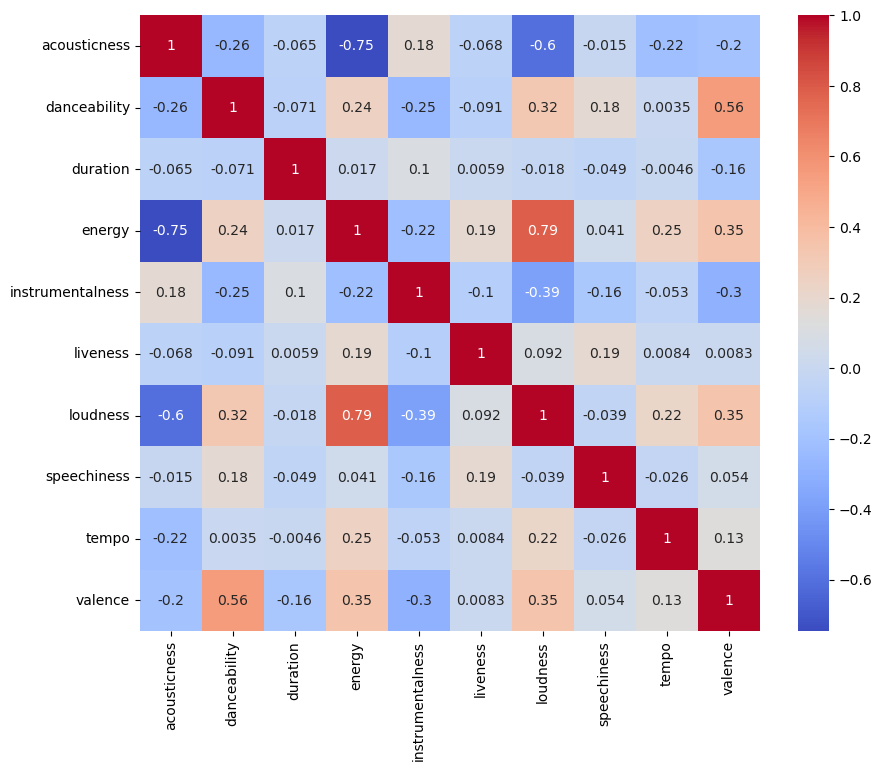

In [31]:
plot_corr_matrix(df, get_features(df))

We can see strong correlations between certain features - namely between energy and acousticness, energy and loudness. In order to reduce complexity of the data we are going to get rid of these correlations later.

### Processing features

##### Removing dominant zeros

First we are going to drop all records with 0 instrumentaless to reduce its dominance in the dataset

In [18]:
df = drop_zeros(df, "instrumentalness")

##### Removing outliers

We are going to remove outliers from the data using IQR method. We are going to do it for popular and unpopular songs separately

In [19]:
def calc_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

def drop_outliers_IQR(df, column):
    Q1, Q3, IQR = calc_IQR(df, column)
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    df = df.loc[(df[column] < upper) & (df[column] > lower)]
    return df

In [20]:
df_pop = df.loc[df["label"] == 1]
df_non_pop = df.loc[df["label"] == 0]

for feature in get_features(df):
    df_pop = drop_outliers_IQR(df_pop, feature)
    df_non_pop = drop_outliers_IQR(df_non_pop, feature)

df = pd.concat([df_pop, df_non_pop])

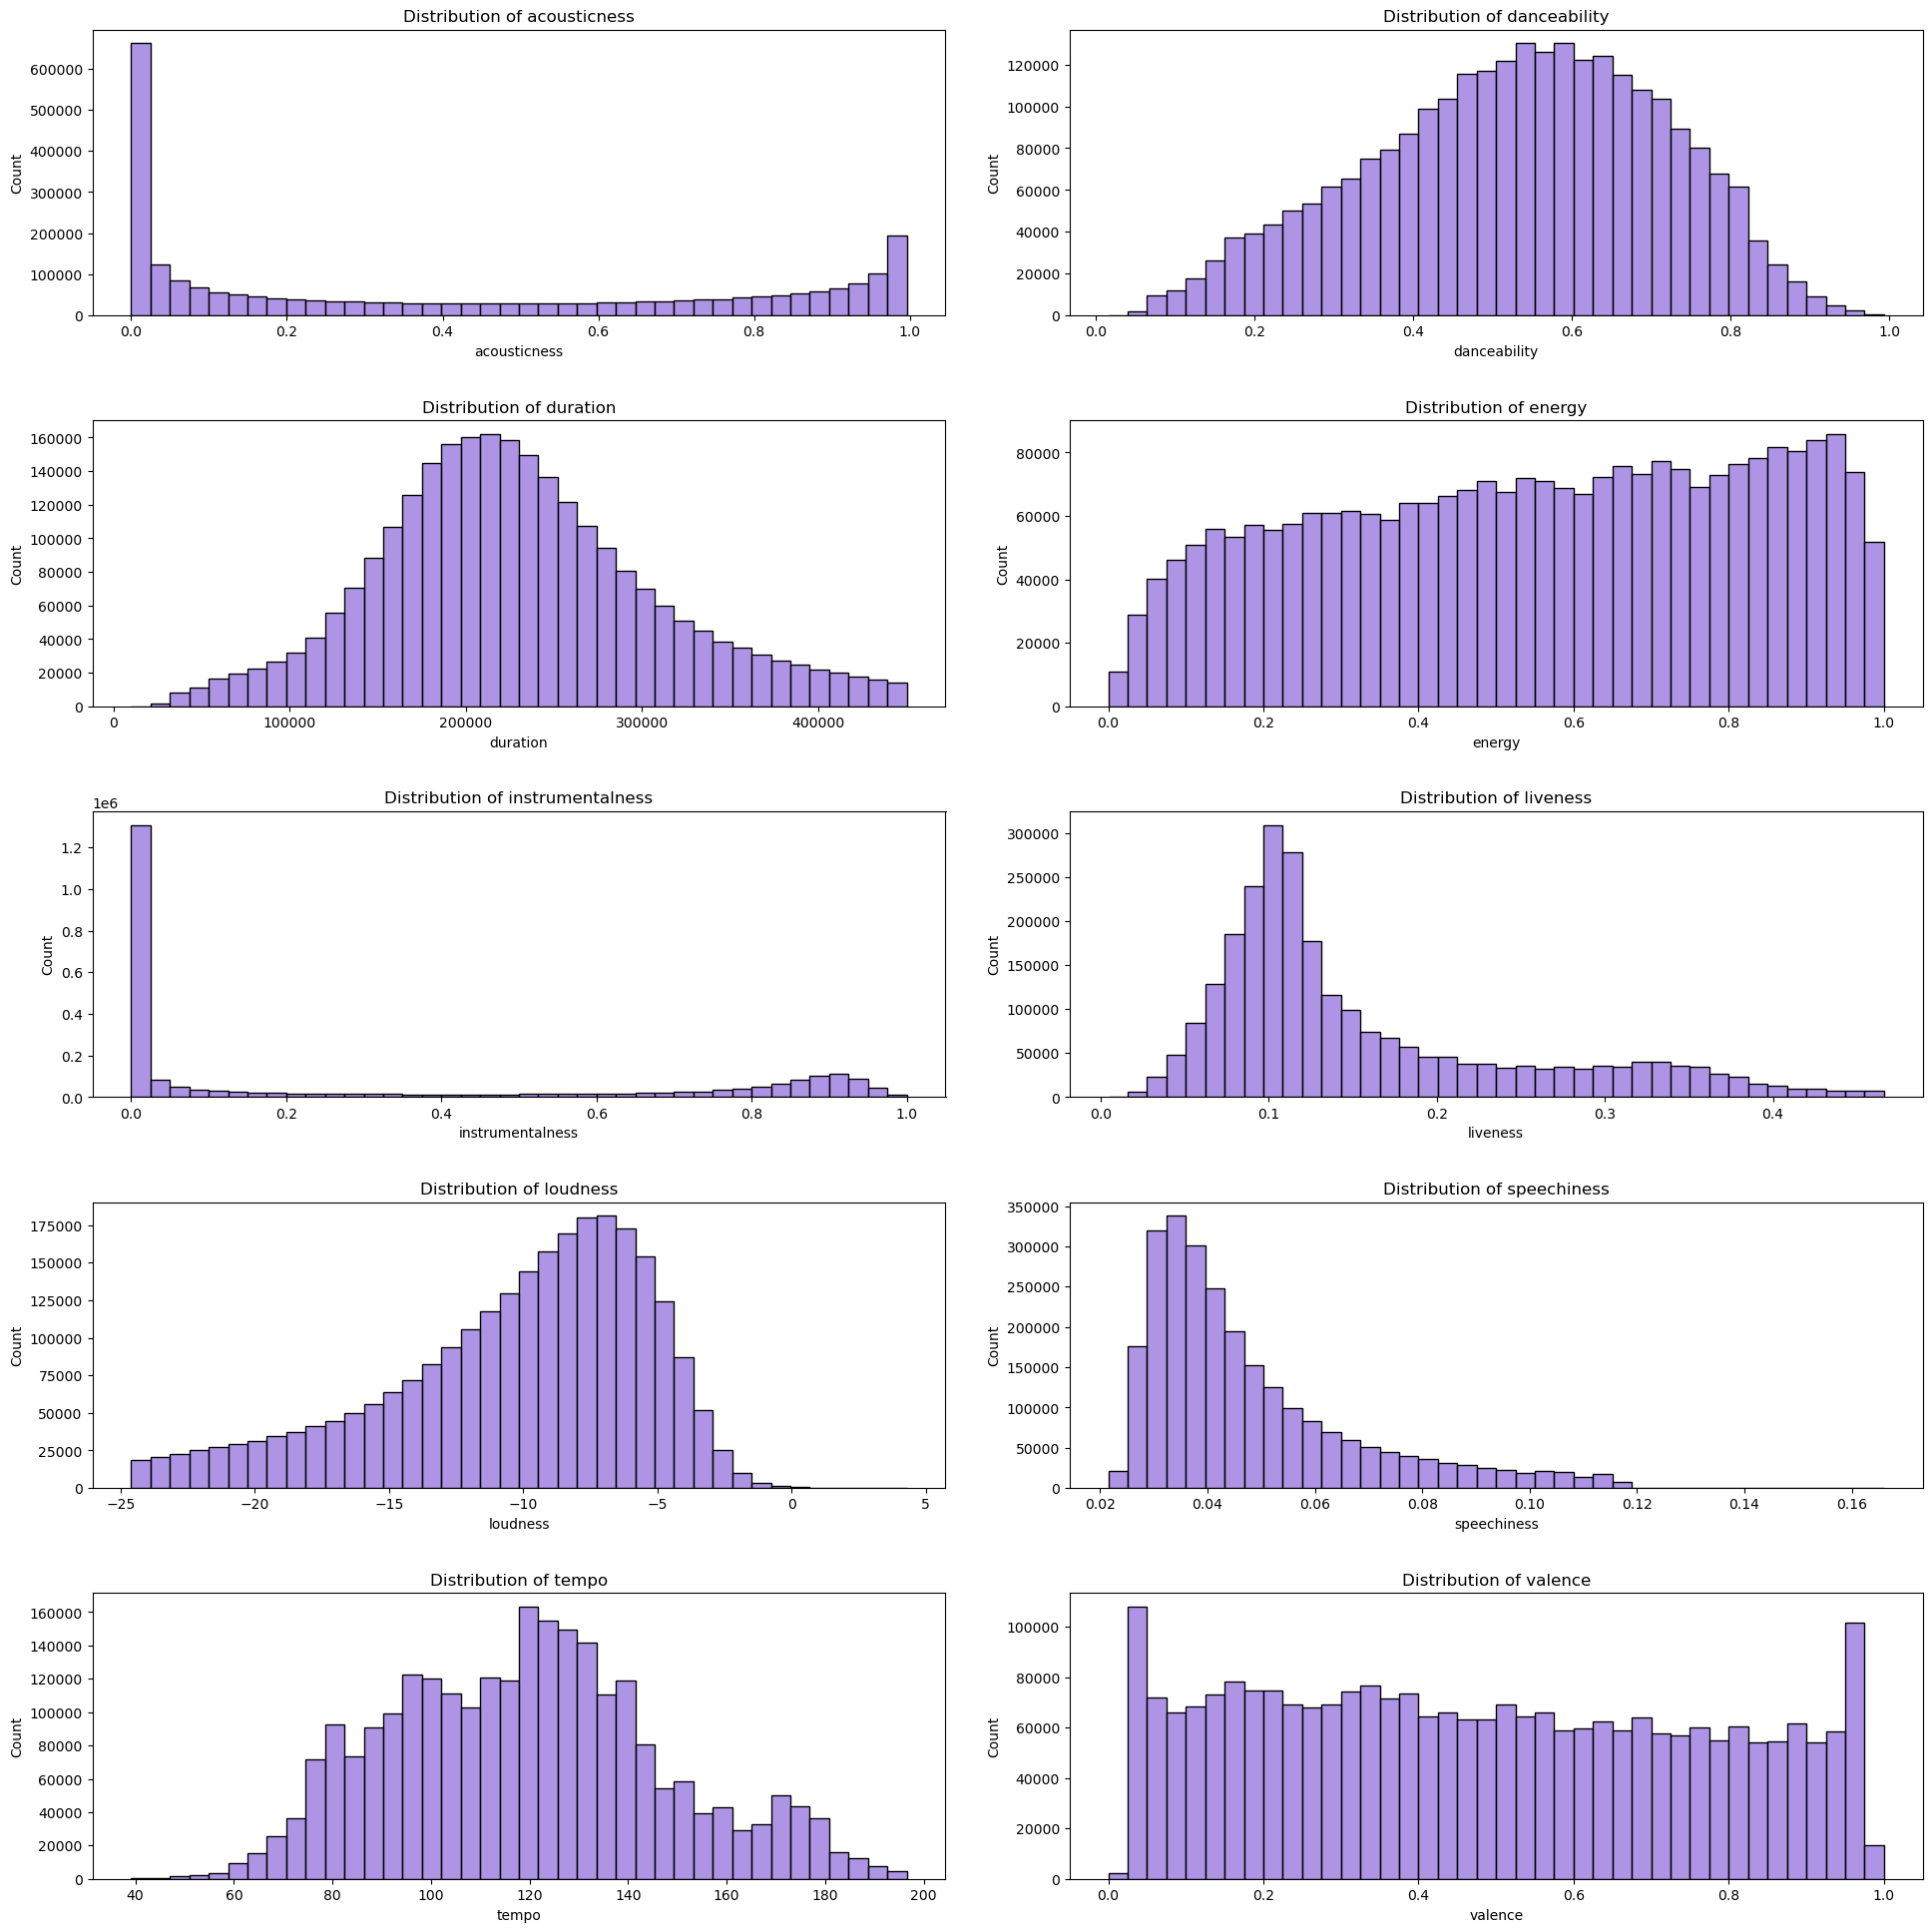

In [35]:
plot_dist(df)

We can see on plots above, that while the features are still far from being normally distributed, they are now more balanced and there are no clear outliers.

#### Removing correlations

As energy was a feature strongly correlating with two other features (with absolute correlation index > 0.75), we are going to remove it from the dataset. 

In [21]:
df = df.drop("energy", axis=1)

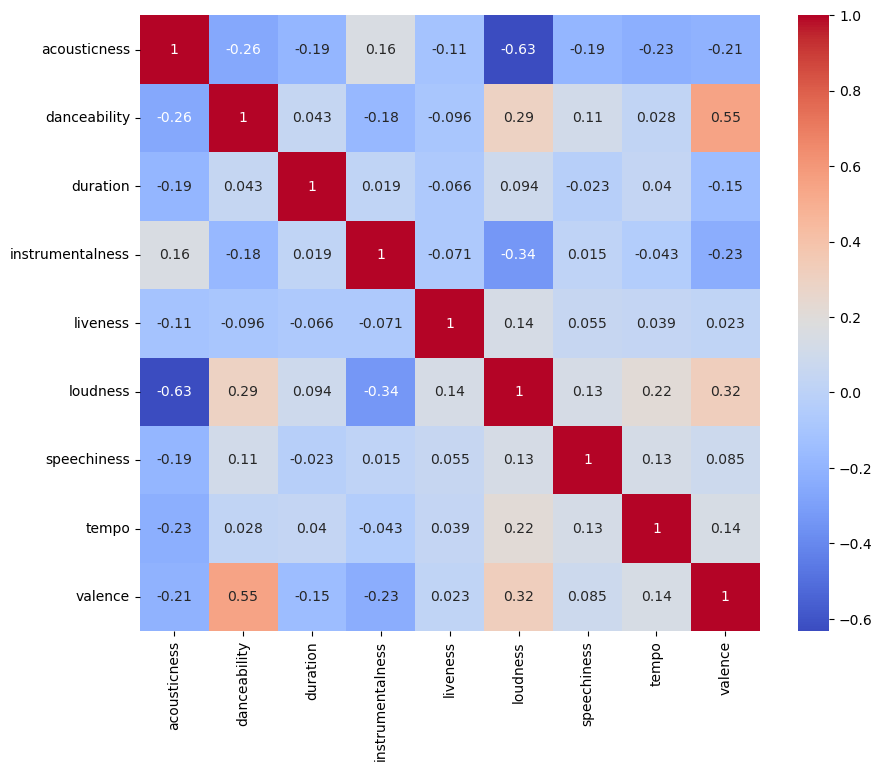

In [37]:
plot_corr_matrix(df, get_features(df))

Now the highest absolute correlation is 0.64, which is low enough for this experiment.

##### Binning data

The features are distributed very differently from each other. To improve the data for training, we are going to bin the features, using the Freedman-Diaconis rule. 

In [22]:
def FD_rule_width(df, feature):
    IQR = calc_IQR(df, feature)[2]
    width = 2 * (IQR / (len(df) ** (1/3)))
    return width

def FD_rule_bin(df, feature):
    nbins = int((max(df[feature]) - min(df[feature])) / FD_rule_width(df, feature))
    return pd.cut(df[feature], nbins, labels=np.arange(nbins))

def bin_feature(df, feature):
    df[feature] = FD_rule_bin(df, feature)
    return df

In [23]:
for feature in get_features(df):
    df = bin_feature(df, feature)

In [24]:
df.head(10)

,acousticness,danceability,duration,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,label
23,1,196,205,0,188,193,430,151,105,68,1
73,17,199,233,1,60,171,67,149,44,56,1
74,17,201,130,0,72,175,224,151,51,63,1
188,8,177,144,0,52,206,112,95,133,65,1
213,17,240,104,0,43,230,85,159,125,56,1
291,42,161,124,0,77,166,115,80,9,57,1
365,47,66,118,1,217,165,24,84,45,77,1
366,58,170,112,0,65,157,34,147,134,67,1
377,4,159,190,0,46,200,16,133,87,66,1
385,4,163,181,4,88,174,10,157,107,68,1


In [43]:
len(df)

2567493

## Data splitting and scaling

For the experiment we are going to use a smaller sample of the data.

In [32]:
pop_count = df["label"].value_counts()[1]

In [41]:
df_pop = df.loc[df["label"] == 1]
df_non_pop = df.loc[df["label"] == 0].sample(50000, random_state=random_state)
df_sample = pd.concat([df_pop, df_non_pop])

In [42]:
df_sample["label"].value_counts()

label
0    50000
1    27302
Name: count, dtype: int64

As we see, there is a massive imbalance in the dataset. We are going to use SMOTE to synthesize new samples of popular songs.

In [34]:
X = df_sample.drop(["popularity", "label"], axis=1)
y = df_sample["label"]

In [35]:
X, y = SMOTE(random_state=random_state).fit_resample(X, y)

In [36]:
X = StandardScaler().fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Model selection

We are going to use GridSearchCV to find the best hyperparameters for the models. We are going to use the following models: Logistic Regression, Random Forest, K-Nearest Neighbours and SVM.

#### Grid Search

In [61]:
def grid_search(model, params, X, y):
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid.fit(X, y)
    return grid.best_estimator_

#### Logistic Regression

In [62]:
log_reg = LogisticRegression()

log_reg_params = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear"],
}

log_reg = grid_search(log_reg, log_reg_params, X_train, y_train)


#### Random Forest

In [63]:
random_forest = RandomForestClassifier()

rf_params = {
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}

random_forest = grid_search(random_forest, rf_params, X_train, y_train)

#### K-Nearest Neighbours

In [64]:
kneighbors = KNeighborsClassifier()

kneighbors_params = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

kneighbors = grid_search(kneighbors, kneighbors_params, X_train, y_train)

#### SVM

In [65]:
svc = SVC()

svc_params = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf"],
}

svc = grid_search(svc, svc_params, X_train, y_train)

In [102]:
models = {
    "Logistic Regression": log_reg,
    "Random Forest": random_forest,
    "K-Neighbors": kneighbors,
    "SVC": svc,
}

## Model evaluation

In [47]:
log_reg_score = cross_val_score(log_reg, X, y, cv=5, scoring="f1")
random_forest_score = cross_val_score(random_forest, X, y, cv=5, scoring="f1")
kneighbors_score = cross_val_score(kneighbors, X, y, cv=5, scoring="f1")
svc_score = cross_val_score(svc, X, y, cv=5, scoring="f1")

In [48]:
scores = pd.Series(data={"Logistic Regression": log_reg_score.mean(), 
                            "Random Forest": random_forest_score.mean(), 
                            "K-Neighbors": kneighbors_score.mean(), 
                            "SVC": svc_score.mean()})

In [49]:
pd.DataFrame(scores, columns=["F1 Score"])

,F1 Score
Logistic Regression,0.773758
Random Forest,0.796669
K-Neighbors,0.825193
SVC,0.809717


<Axes: >

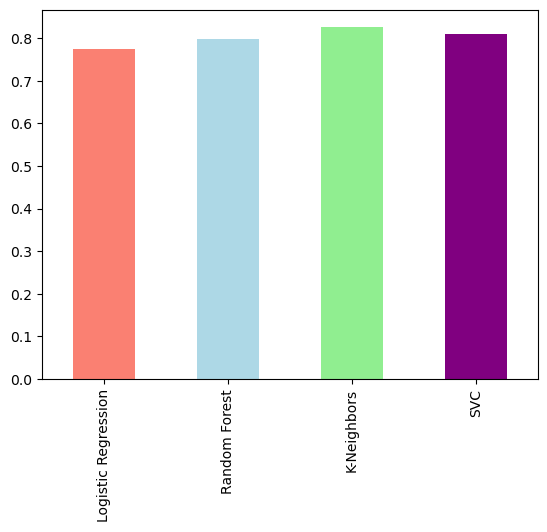

In [50]:
scores.plot(kind="bar", color=["salmon", "lightblue", "lightgreen", "purple"])

### Confusion matrix

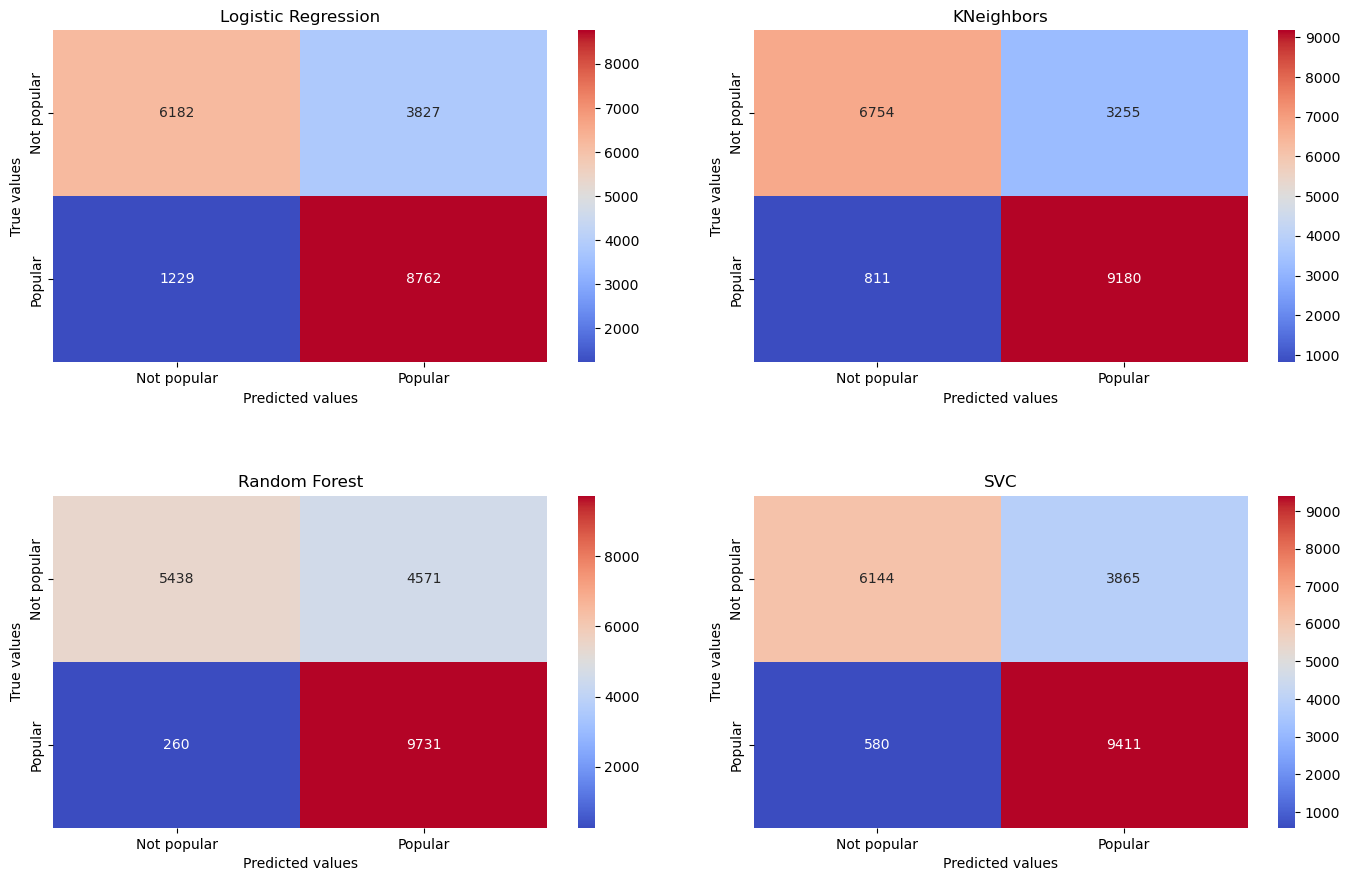

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, (name, model) in enumerate(models.items()):
    ax = axes[int(i / 2), i % 2]
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, ax=ax, cmap="coolwarm", fmt="d")
    ax.set_title(name)
    ax.set_xlabel("Predicted values")
    ax.set_ylabel("True values")
    ax.set_xticklabels(["Not popular", "Popular"])
    ax.set_yticklabels(["Not popular", "Popular"])
    plt.tight_layout(pad=5)
plt.show()

## Conclusions

The best model for this experiment was K-Nearest Neighbours Classifier. The other models were also performing well, with the difference being around 7.5%. The experiment shows, that it is possible to predict, whether or not a song will be popular, based on its features.

To increase model's performace in the future, we could:
- use more data
- use more features, e.g. information about the artist, lyrics etc.
- use more advanced models, e.g. neural networks

In [29]:
import pickle

In [27]:
def load_models():
    models = {}
    models["Logistic Regression"] = pickle.load(open("models/log_reg.pkl", "rb"))
    models["KNeighbors"] = pickle.load(open("models/kneighbors.pkl", "rb"))
    models["Random Forest"] = pickle.load(open("models/random_forest.pkl", "rb"))
    models["SVC"] = pickle.load(open("models/svc.pkl", "rb"))
    return models

In [30]:
models = load_models()

In [45]:
log_reg, kneighbors, random_forest, svc = models.values()